In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the dataset
train_csv_path = '/content/drive/My Drive/Colab Notebooks/archive/sign_mnist_train.csv'
test_csv_path = '/content/drive/My Drive/Colab Notebooks/archive/sign_mnist_test.csv'

# Load the datasets
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CustomLDA:
    def __init__(self):
        self.class_means = None
        self.priors = None
        self.scalings = None

    def fit(self, X, y, n_components=None):
        """
        Fit the LDA model to the training data.
        :param X: Feature matrix (n_samples, n_features)
        :param y: Target vector (n_samples,)
        """
        # Find unique classes
        classes = np.unique(y)
        self.class_means = {}
        self.priors = {}
        overall_mean = np.mean(X, axis=0)

        # Calculate within-class scatter matrix
        S_W = np.zeros((X.shape[1], X.shape[1]))
        S_B = np.zeros((X.shape[1], X.shape[1]))

        for cls in classes:
            # Extract data for the current class
            X_cls = X[y == cls]

            # Calculate class mean
            mean_cls = np.mean(X_cls, axis=0)
            self.class_means[cls] = mean_cls

            # Class prior probability
            self.priors[cls] = len(X_cls) / len(X)

            # Within-class scatter
            S_W += np.dot((X_cls - mean_cls).T, (X_cls - mean_cls))

            # Between-class scatter
            mean_diff = (mean_cls - overall_mean).reshape(-1, 1)
            S_B += len(X_cls) * np.dot(mean_diff, mean_diff.T)

        # Solve the eigenvalue problem
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eig_vals)[::-1]
        eig_vecs = eig_vecs[:, sorted_indices]

        if n_components is None or n_components > len(classes) - 1:
          n_components = len(classes) - 1  # Max possible components

        # Keep only the top components
        self.scalings = eig_vecs.real[:, :n_components]

        # Project data onto the LDA subspace
        X_projected = np.dot(X, self.scalings[:, :len(classes) - 1])

        # Update class means in the reduced-dimensional space
        self.class_means = {cls: np.mean(X_projected[y == cls], axis=0) for cls in classes}

    def transform(self, X, n_components=None):
        """
        Project data onto the LDA components.
        :param X: Feature matrix (n_samples, n_features)
        :param n_components: Number of components to keep
        """
        if n_components is None:
            n_components = self.scalings.shape[1]
        return np.dot(X, self.scalings[:, :n_components])

    def predict(self, X):
        """
        Predict class labels for the input data.
        :param X: Feature matrix (n_samples, n_features)
        """
        X_projected = np.dot(X, self.scalings)

        predictions = []
        for x in X:
            distances = {cls: np.linalg.norm(x - mean) for cls, mean in self.class_means.items()}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)


In [ ]:
class CustomPCA:
    def __init__(self, n_components=None, variance_threshold=None):
        """
        Initialize CustomPCA.
        :param n_components: Number of principal components to retain (optional).
        :param variance_threshold: Fraction of variance to retain (optional).
        """
        self.n_components = n_components
        self.variance_threshold = variance_threshold
        self.components = None  # Principal components
        self.mean = None        # Mean of each feature

    def fit_transform(self, X):
        """
        Fit the PCA model and transform the data.
        :param X: Feature matrix (n_samples, n_features)
        :return: Transformed data with reduced dimensions
        """
        # Center the data by subtracting the mean
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Compute the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Select the number of components based on n_components or variance threshold
        if self.n_components is not None:
            eigenvectors = eigenvectors[:, :self.n_components]
        elif self.variance_threshold is not None:
            total_variance = np.sum(eigenvalues)
            variance_retained = 0
            num_components = 0
            for eigenvalue in eigenvalues:
                variance_retained += eigenvalue
                num_components += 1
                if variance_retained / total_variance >= self.variance_threshold:
                    break
            eigenvectors = eigenvectors[:, :num_components]

        self.components = eigenvectors

        # Project data onto the selected principal components
        return np.dot(X_centered, self.components)

    def transform(self, X):
        """
        Transform data using the fitted PCA model.
        :param X: Feature matrix (n_samples, n_features)
        :return: Transformed data
        """
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)


In [ ]:
def custom_accuracy_score(y_true, y_pred):
    """
    Compute accuracy manually.

    Parameters:
        y_true: Array of true labels
        y_pred: Array of predicted labels

    Returns:
        Accuracy score as a float
    """
       # Ensure both inputs are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Check if the shapes match
    assert y_true.shape == y_pred.shape, "Shape mismatch: y_true and y_pred must have the same shape."

    correct_predictions = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
    accuracy = correct_predictions / len(y_true)
    return accuracy



def custom_confusion_matrix(y_true, y_pred, num_classes, class_names=None):
    """
    Compute the confusion matrix manually and plot it with a stylish design.

    Parameters:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        num_classes: Number of unique classes
        class_names: List of class names corresponding to the classes (optional)

    Returns:
        Confusion matrix as a 2D numpy array
    """

    # Initialize confusion matrix
    matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1  # Increment the cell corresponding to (true, predicted)

    # Plotting the styled confusion matrix
    plt.figure(figsize=(12,10))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes),
                linewidths=0.5, linecolor='black')

    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

    return matrix


def custom_classification_report(y_true, y_pred, num_classes, class_names=None):
    """
    Compute and display the classification report in a styled table format.

    Parameters:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        num_classes: Number of unique classes
        class_names: List of class names (optional)

    Returns:
        A pandas DataFrame containing precision, recall, F1-score, and support.
    """
    import pandas as pd
    import numpy as np

    # Compute confusion matrix
    cm = custom_confusion_matrix(y_true, y_pred, num_classes)

    # Initialize report dictionary
    report = {}
    for cls in range(num_classes):
        true_positive = cm[cls, cls]
        false_positive = sum(cm[:, cls]) - true_positive
        false_negative = sum(cm[cls, :]) - true_positive

        # Handle cases with no positive or negative samples for this class
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        support = sum(y_true == cls)

        report[cls] = {
            "precision": precision,
            "recall": recall,
            "f1-score": f1_score,
            "support": support
        }

    # Convert the report dictionary to a DataFrame
    class_names = class_names if class_names else [f"Class {i}" for i in range(num_classes)]
    df_report = pd.DataFrame.from_dict(report, orient='index')
    df_report.index = class_names

    # Add average metrics
    macro_avg = df_report[["precision", "recall", "f1-score"]].mean()
    weighted_avg = df_report[["precision", "recall", "f1-score"]].multiply(df_report["support"], axis=0).sum() / df_report["support"].sum()

    df_report.loc["macro avg"] = macro_avg
    df_report.loc["weighted avg"] = weighted_avg

    print("Accuracy: ", sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred)) / len(y_true))

    return df_report




### Calculating the accuracy of LDA without PCA

In [ ]:
# Train LDA directly on the original data
lda = CustomLDA()
lda.fit(X_train, y_train)

# Transform test data
# Use n_components = min(n_classes - 1, n_features)
X_test_lda = lda.transform(X_test, n_components=23)

# Predict
y_pred = lda.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Without PCA: {accuracy:.2f}")

Accuracy Without PCA: 0.43


Accuracy Without PCA: 0.43


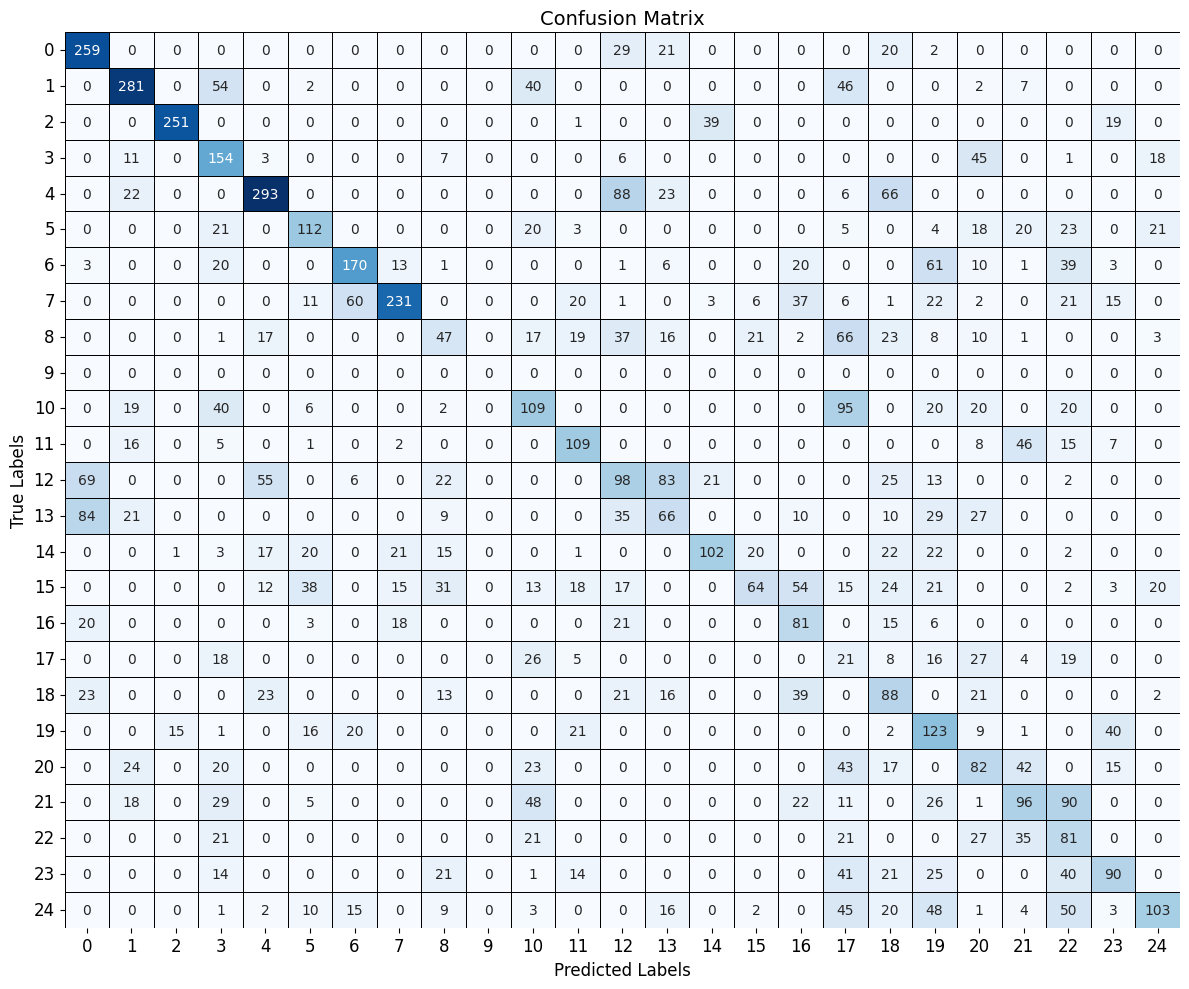

Accuracy:  0.4337702175125488
              precision    recall  f1-score  support
0              0.565502  0.782477  0.656527    331.0
1              0.682039  0.650463  0.665877    432.0
2              0.940075  0.809677  0.870017    310.0
3              0.383085  0.628571  0.476043    245.0
4              0.694313  0.588353  0.636957    498.0
5              0.500000  0.453441  0.475584    247.0
6              0.627306  0.488506  0.549273    348.0
7              0.770000  0.529817  0.627717    436.0
8              0.265537  0.163194  0.202151    288.0
9              0.000000  0.000000  0.000000      0.0
10             0.339564  0.329305  0.334356    331.0
11             0.516588  0.521531  0.519048    209.0
12             0.276836  0.248731  0.262032    394.0
13             0.267206  0.226804  0.245353    291.0
14             0.618182  0.414634  0.496350    246.0
15             0.566372  0.184438  0.278261    347.0
16             0.305660  0.493902  0.377622    164.0
17             0

In [ ]:
# Train LDA directly on the original data
lda = CustomLDA()
lda.fit(X_train, y_train)

# Transform test data
# Use n_components = min(n_classes - 1, n_features)
X_test_lda = lda.transform(X_test, n_components=23)

# Predict
y_pred = lda.predict(X_test_lda)

# Compute accuracy
accuracy = custom_accuracy_score(y_test, y_pred)
print(f"Accuracy Without PCA: {accuracy:.2f}")

# Number of unique classes
num_classes = len(np.unique(y_test)) + 1

# Optional: Define class names (e.g., 0-23 for Sign Language MNIST)
class_names = [str(i) for i in range(num_classes)]

# Generate and display the confusion matrix
# custom_confusion_matrix(y_test, y_pred, num_classes=num_classes, class_names=class_names)

# Generate and display the classification report
classification_report = custom_classification_report(y_test, y_pred,num_classes=num_classes, class_names=class_names)
print(classification_report)

### Calculating the Model accuracy with Custom PCA and Custom LDA

Accuracy with Custom PCA and Custom LDA: 0.62


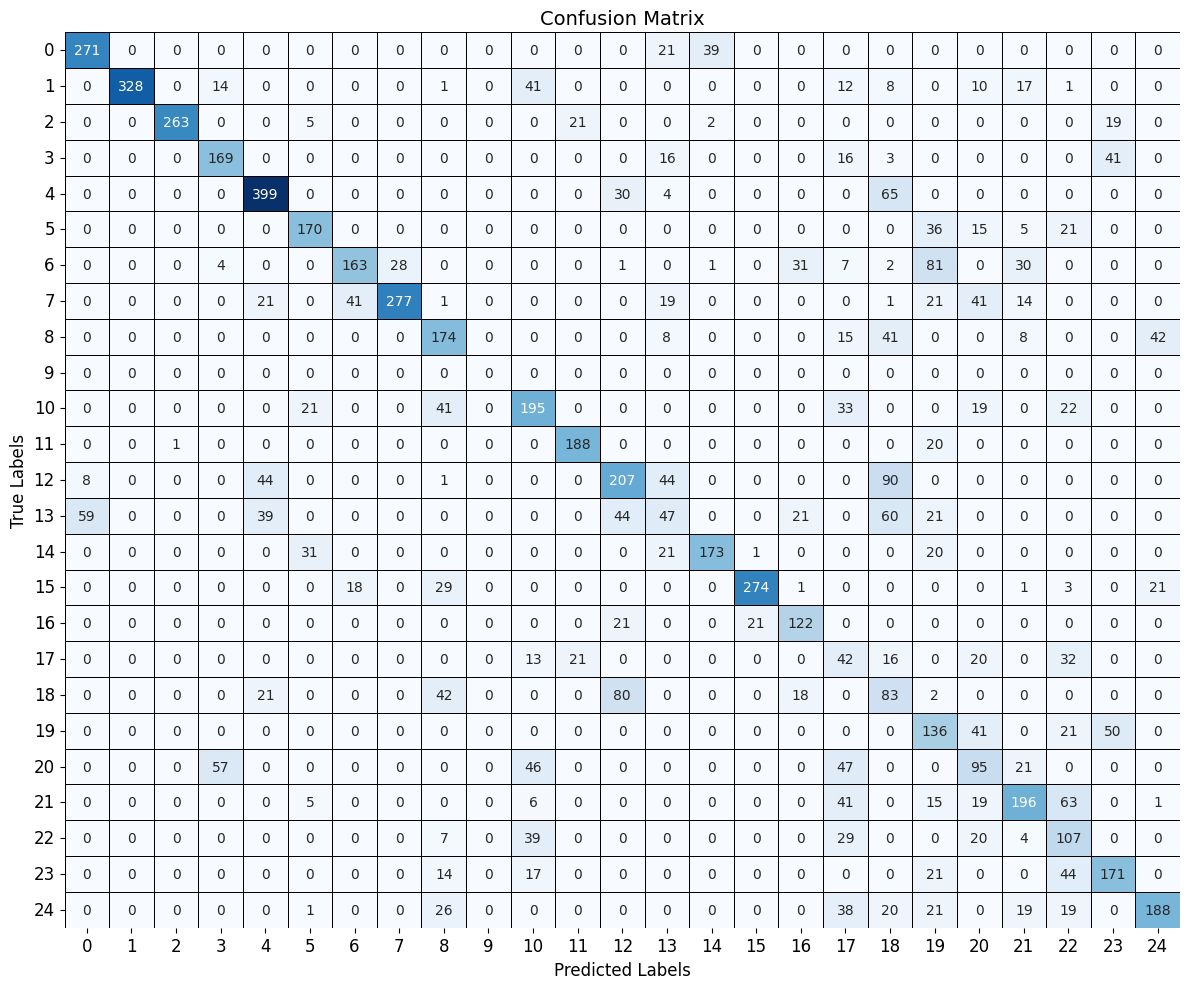

Accuracy:  0.6187953151143335
              precision    recall  f1-score  support
0              0.801775  0.818731  0.810164    331.0
1              1.000000  0.759259  0.863158    432.0
2              0.996212  0.848387  0.916376    310.0
3              0.692623  0.689796  0.691207    245.0
4              0.761450  0.801205  0.780822    498.0
5              0.729614  0.688259  0.708333    247.0
6              0.734234  0.468391  0.571930    348.0
7              0.908197  0.635321  0.747638    436.0
8              0.517857  0.604167  0.557692    288.0
9              0.000000  0.000000  0.000000      0.0
10             0.546218  0.589124  0.566860    331.0
11             0.817391  0.899522  0.856492    209.0
12             0.540470  0.525381  0.532819    394.0
13             0.261111  0.161512  0.199575    291.0
14             0.804651  0.703252  0.750542    246.0
15             0.925676  0.789625  0.852255    347.0
16             0.632124  0.743902  0.683473    164.0
17             0

In [ ]:
# Apply Custom PCA to reduce dimensionality
custom_pca = CustomPCA(variance_threshold=0.95)  # Retain 95% variance
X_train_pca = custom_pca.fit_transform(X_train)
X_test_pca = custom_pca.transform(X_test)

# Train LDA on Custom PCA-transformed data
lda = CustomLDA()
lda.fit(X_train_pca, y_train)

# Transform test data
X_test_lda = lda.transform(X_test_pca, n_components=23)

# Predict
y_pred = lda.predict(X_test_lda)

# Evaluate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)
print(f"Accuracy with Custom PCA and Custom LDA: {accuracy:.2f}")

# Number of unique classes
num_classes = len(np.unique(y_test)) + 1

# Optional: Define class names (e.g., 0-23 for Sign Language MNIST)
class_names = [str(i) for i in range(num_classes)]

# Generate and display the classification report
classification_report = custom_classification_report(y_test, y_pred, num_classes=num_classes, class_names=class_names)
print(classification_report)


## Scatter Plots

After applying dimensionality reduction techniques like PCA (Principal Component Analysis) and LDA (Linear Discriminant Analysis), we can use scatter plots to:

1.Visualize the transformed data in lower dimensions.
2. Assess how well the classes are separated after transformation.
3. Identify any overlaps or misclassifications between classes.

After LDA Transformation

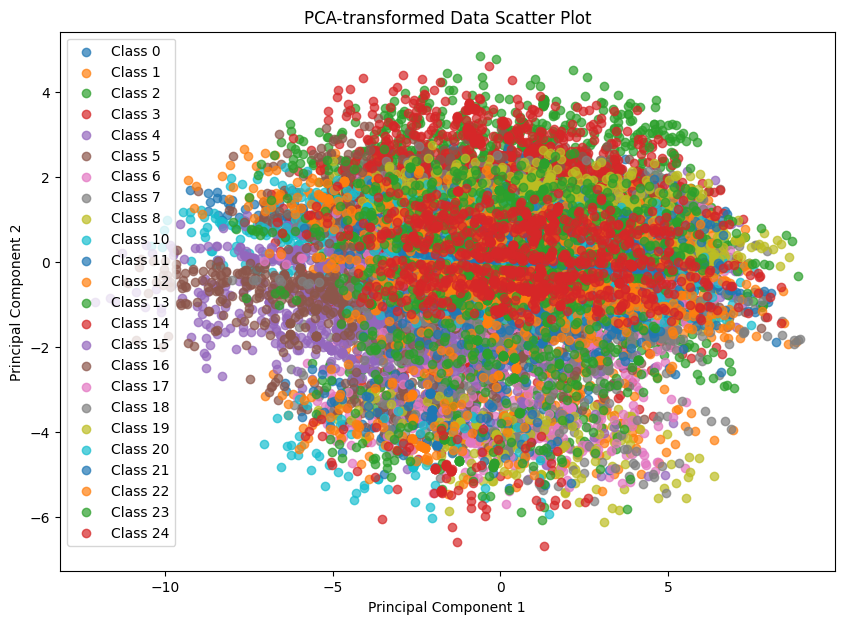

In [ ]:
# Select the first two principal components for 2D plotting
plt.figure(figsize=(10, 7))
for class_label in np.unique(y_train):
    plt.scatter(
        X_train_pca[y_train == class_label, 0],
        X_train_pca[y_train == class_label, 1],
        label=f'Class {class_label}',
        alpha=0.7
    )
plt.title('PCA-transformed Data Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


After LDA Transformation

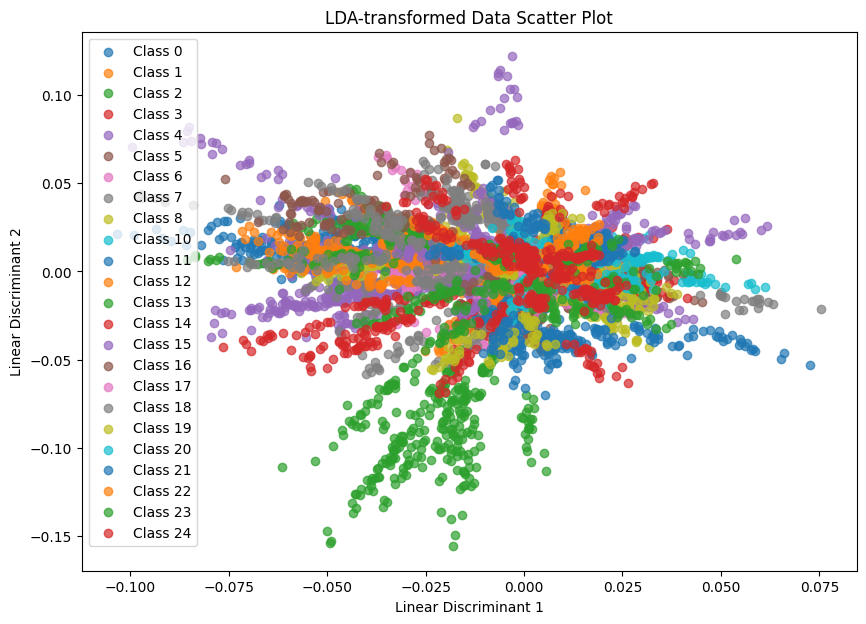

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test_lda is your LDA-transformed test data
# and y_test contains the true class labels

# Check if the data has at least 2 components
if X_test_lda.shape[1] >= 2:
    plt.figure(figsize=(10, 7))
    for class_label in np.unique(y_test):
        plt.scatter(
            X_test_lda[y_test == class_label, 0],
            X_test_lda[y_test == class_label, 1],
            label=f'Class {class_label}',
            alpha=0.7
        )
    plt.title('LDA-transformed Data Scatter Plot')
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    plt.legend()
    plt.show()
else:
    # If only one component, plot a histogram
    plt.figure(figsize=(10, 7))
    for class_label in np.unique(y_test):
        plt.hist(
            X_test_lda[y_test == class_label],
            bins=20,
            alpha=0.7,
            label=f'Class {class_label}'
        )
    plt.title('LDA-transformed Data Histogram')
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


3D Scatter Plot

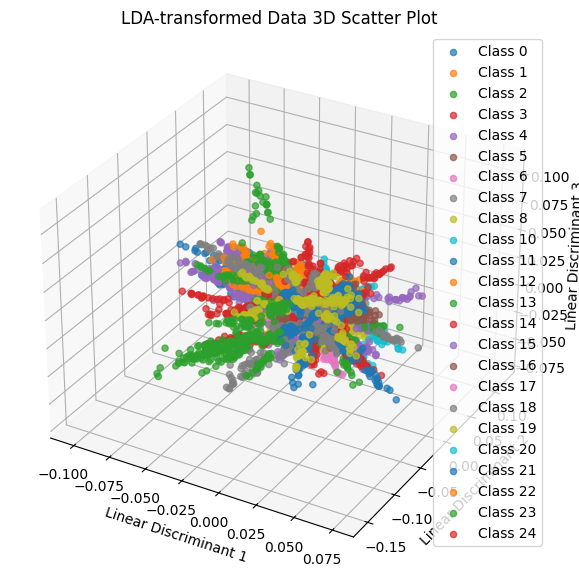

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

if X_test_lda.shape[1] >= 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    for class_label in np.unique(y_test):
        ax.scatter(
            X_test_lda[y_test == class_label, 0],
            X_test_lda[y_test == class_label, 1],
            X_test_lda[y_test == class_label, 2],
            label=f'Class {class_label}',
            alpha=0.7
        )
    ax.set_title('LDA-transformed Data 3D Scatter Plot')
    ax.set_xlabel('Linear Discriminant 1')
    ax.set_ylabel('Linear Discriminant 2')
    ax.set_zlabel('Linear Discriminant 3')
    plt.legend()
    plt.show()


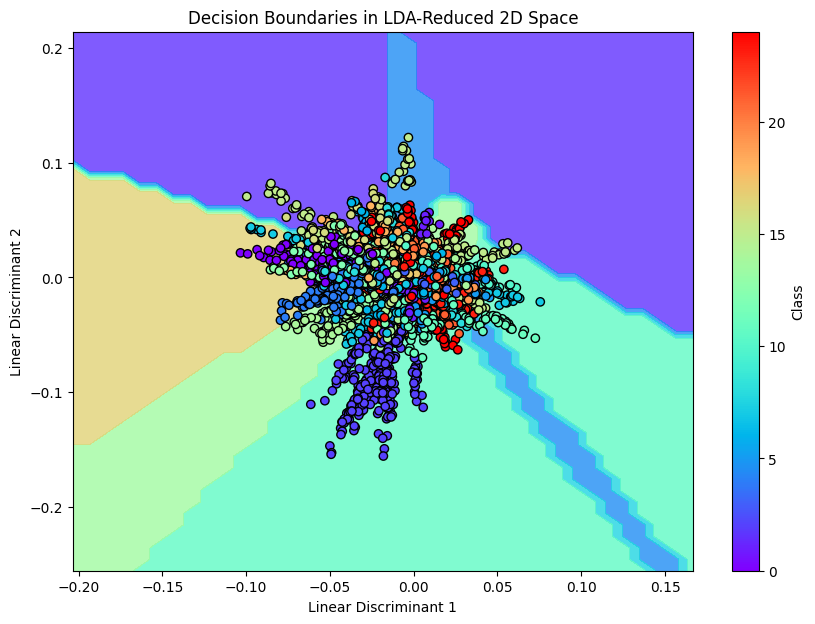

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Select the first two LDA components for visualization
X_train_2d = X_test_lda[:, :2]  # Use the first two components
y_train_2d = y_test             # Corresponding labels

# Train the classifier on the 2D LDA space

classifier = CustomLDA()
classifier.fit(X_train_2d, y_train_2d)

# Generate a mesh grid for decision boundary visualization
x_min, x_max = X_train_2d[:, 0].min() - 0.1, X_train_2d[:, 0].max() + 0.1
y_min, y_max = X_train_2d[:, 1].min() - 0.1, X_train_2d[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the class for each point on the grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.rainbow)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_2d, edgecolors='k', cmap=plt.cm.rainbow)
plt.title("Decision Boundaries in LDA-Reduced 2D Space")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar(label="Class")
plt.show()


X_train_3d shape: (7172, 3)
y_train shape: (27455,)


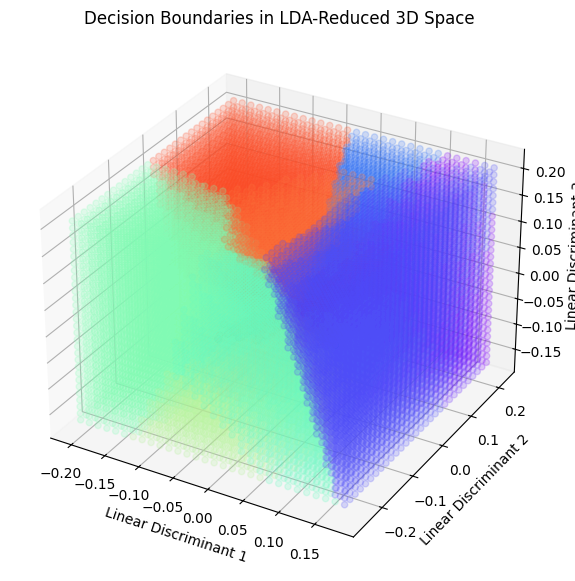

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Select three components for 3D visualization
X_train_3d = X_test_lda[:, :3]  # Use the first three components

print(f"X_train_3d shape: {X_train_3d.shape}")
print(f"y_train shape: {y_train.shape}")

# Align y_train with X_train_3d
y_train_3d = y_train[:X_train_3d.shape[0]]

lda = CustomLDA()
lda.fit(X_train_3d, y_train_3d)


# Generate a grid in 3D
x_min, x_max = X_train_3d[:, 0].min() - 0.1, X_train_3d[:, 0].max() + 0.1
y_min, y_max = X_train_3d[:, 1].min() - 0.1, X_train_3d[:, 1].max() + 0.1
z_min, z_max = X_train_3d[:, 2].min() - 0.1, X_train_3d[:, 2].max() + 0.1

xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 30),
                         np.linspace(y_min, y_max, 30),
                         np.linspace(z_min, z_max, 30))

# Predict the class for each point on the grid
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = lda.predict(grid_points)
Z = Z.reshape(xx.shape)

# Visualize decision boundaries in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot grid points with their predicted class
ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], c=Z, alpha=0.2, cmap=plt.cm.rainbow)
ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=y_train_3d, edgecolors='k', cmap=plt.cm.rainbow)
ax.set_title("Decision Boundaries in LDA-Reduced 3D Space")
ax.set_xlabel("Linear Discriminant 1")
ax.set_ylabel("Linear Discriminant 2")
ax.set_zlabel("Linear Discriminant 3")
plt.show()
